# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys
from joblib import delayed, Parallel

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression, HuberRegressor
project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


# Load data

In [12]:
filter_dates = [20200724, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20200724_reproduce_red_n2_train_mass_ss/v19_rep2
    20200724_reproduce_red_n2_train_mass_ss/v19_rep4
    20200724_reproduce_red_n2_train_mass_ss/v19_rep1
    20200724_reproduce_red_n2_train_mass_ss/v19_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep2
    20200724_reproduce_red_n2_train_mass_ss/v11_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep4
    20200724_reproduce_red_n2_train_mass_ss/v11_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep3
    20200724_reproduce_red_n2_train_mass_kc/v19_rep2
    20200724_reproduce_red_n2_train_mass_kc/v19_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep3
    20200724_reproduce_red_n2_train_mass_kc/v11_rep2
    20200724_reproduce_red_n2_train_mass_kc/v11_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep1
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep2
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep1
    20200914_fft_based_norm_

In [15]:
dataset_name = constants.MASS_SS_NAME
which_expert = 1
seed_id_list = [i for i in range(4)]
task_mode = constants.N2_RECORD
fs = 200
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]

# Specify what to load
comparison_runs_list = [
    ('20200724_reproduce_red_n2_train_mass_ss/v19_rep1', 'RED-CWT', 'v19')
    #('20191227_bsf_10runs_e1_n2_train_mass_ss/v11', 'RED-Time', 'v11'),
    # ('20191227_bsf_10runs_e1_n2_train_mass_ss/v19', 'RED-CWT', 'v19'),
    #('20191227_bsf_10runs_e2_n2_train_mass_ss/v11', 'RED-Time', 'v11'),
    #('20191227_bsf_10runs_e2_n2_train_mass_ss/v19', 'RED-CWT', 'v19'),
    #('20191227_bsf_10runs_e1_n2_train_mass_kc/v11', 'RED-Time', 'v11'),
    #('20191227_bsf_10runs_e1_n2_train_mass_kc/v19', 'RED-CWT', 'v19'),
]
comparison_runs_list = [
    (t_folder, t_label, t_code) 
    for (t_folder, t_label, t_code) in comparison_runs_list 
    if (dataset_name in t_folder)
    # if (dataset_name in t_folder) and ('e%d' % which_expert) in t_folder
]
ckpt_folder_list = [t_folder for (t_folder, t_label, t_code) in comparison_runs_list]
ckpt_folder_dict = {t_label: t_folder for (t_folder, t_label, t_code) in comparison_runs_list}
ckpt_label_dict = {t_folder: t_label for (t_folder, t_label, t_code) in comparison_runs_list}
ckpt_label_list = [t_label for (t_folder, t_label, t_code) in comparison_runs_list]
ckpt_code_list = [t_code for (t_folder, t_label, t_code) in comparison_runs_list]

# Load data
n_cases = len(comparison_runs_list)
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = {}
for ckpt_folder in ckpt_folder_list:
    predictions_dict[ckpt_folder] = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
# useful for viz
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper())
expert_data_dict = reader.load_ss_expert_performance()
exp_keys = list(expert_data_dict.keys())
print('\nAvailable data:')
pprint(exp_keys)
model_names = ckpt_label_list
code_names = ckpt_code_list
models = []
for name, code_name in zip(model_names, code_names):
    models.append({'name': name, 'ckpt': ckpt_folder_dict[name], 'code_name': code_name})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed3

Available data:
['iou_curve_axis', 'f1_vs_iou_mean', 'f1_vs_iou_std', 'recall', 'precision']


In [16]:
save_figs = False
save_txt = False
folder_name = 'cheating_%s_e%d' % (dataset_name, which_expert)
os.makedirs(folder_name, exist_ok=True)

## Precision-Recall Curve subjects

Thr grid search: 0.10:0.01:0.95

RED-CWT
(MASS-SS-E1-N2) - ValSet IoU>0.2
S05 (seed0) F1: 77.7 -- Precision 87.3 -- Recall 70.1  (thr 0.52)
S09 (seed0) F1: 85.5 -- Precision 91.6 -- Recall 80.2  (thr 0.52)
S18 (seed0) F1: 80.2 -- Precision 87.8 -- Recall 73.8  (thr 0.52)
S03 (seed1) F1: 77.7 -- Precision 75.3 -- Recall 80.1  (thr 0.56)
S11 (seed1) F1: 80.1 -- Precision 70.4 -- Recall 92.9  (thr 0.56)
S19 (seed1) F1: 79.0 -- Precision 68.7 -- Recall 93.0  (thr 0.56)
S07 (seed2) F1: 79.1 -- Precision 76.9 -- Recall 81.4  (thr 0.56)
S14 (seed2) F1: 76.1 -- Precision 62.4 -- Recall 97.3  (thr 0.56)
S17 (seed2) F1: 82.6 -- Precision 81.6 -- Recall 83.5  (thr 0.56)
S01 (seed3) F1: 85.8 -- Precision 93.0 -- Recall 79.6  (thr 0.48)
S05 (seed3) F1: 72.9 -- Precision 88.5 -- Recall 62.0  (thr 0.48)
S10 (seed3) F1: 85.8 -- Precision 80.5 -- Recall 91.8  (thr 0.48)
Avg F1: 80.2 ± 3.9 -- Precision 80.3 ± 9.4 -- Recall 82.1 ± 10.0


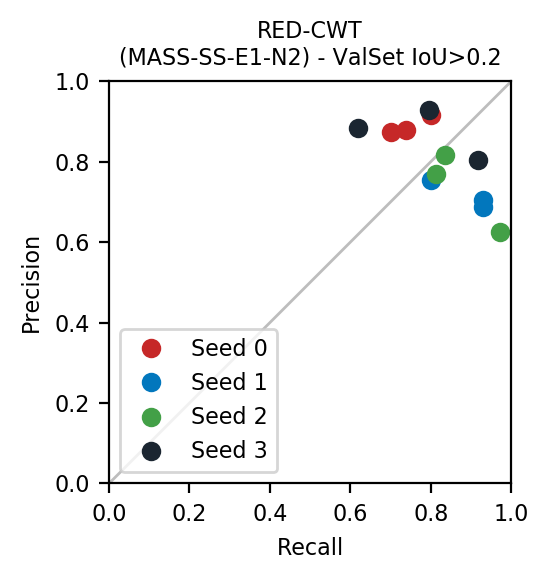


RED-CWT (Cheating)
(MASS-SS-E1-N2) - ValSet IoU>0.2
S05 (seed0) F1: 81.3 -- Precision 79.3 -- Recall 83.5  (thr 0.35)
S09 (seed0) F1: 86.7 -- Precision 86.9 -- Recall 86.5  (thr 0.36)
S18 (seed0) F1: 82.5 -- Precision 81.2 -- Recall 83.9  (thr 0.29)
S03 (seed1) F1: 78.2 -- Precision 81.5 -- Recall 75.2  (thr 0.66)
S11 (seed1) F1: 81.3 -- Precision 73.0 -- Recall 91.7  (thr 0.63)
S19 (seed1) F1: 80.5 -- Precision 74.5 -- Recall 87.6  (thr 0.71)
S07 (seed2) F1: 79.2 -- Precision 77.2 -- Recall 81.3  (thr 0.57)
S14 (seed2) F1: 83.8 -- Precision 77.3 -- Recall 91.5  (thr 0.81)
S17 (seed2) F1: 83.0 -- Precision 80.2 -- Recall 85.9  (thr 0.51)
S01 (seed3) F1: 87.7 -- Precision 90.3 -- Recall 85.2  (thr 0.34)
S05 (seed3) F1: 78.5 -- Precision 83.0 -- Recall 74.6  (thr 0.30)
S10 (seed3) F1: 86.2 -- Precision 81.6 -- Recall 91.3  (thr 0.50)
Avg F1: 82.4 ± 3.1 -- Precision 80.5 ± 4.7 -- Recall 84.8 ± 5.5


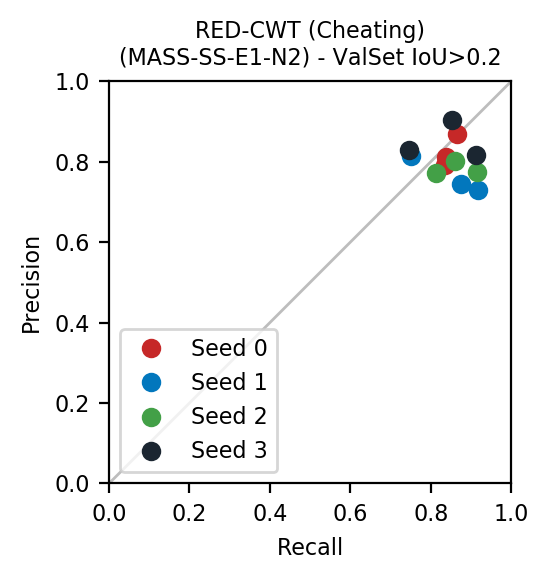

In [17]:
seeds_to_show = seed_id_list
n_seeds = len(seeds_to_show)
set_list = ['val']
iou_to_show = 0.2
dpi = 200
res_thr = 0.01
start_thr = 0.1
end_thr = 0.95
iou_idx = misc.closest_index(iou_to_show, iou_curve_axis) 
color_dict = {
    'train': {i: viz.GREY_COLORS[4] for i in range(4)},
    'val': {0: viz.PALETTE['red'], 1: viz.PALETTE['blue'], 2: viz.PALETTE['green'], 3: viz.PALETTE['dark']}
}
markersize_model = 6
axis_markers = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
n_thr = int(np.floor((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])
thr_list = np.round(thr_list, 2)
if save_txt:
    f = open(os.path.join(folder_name, 'cheating_metrics_xval.txt'), 'w')
print('Thr grid search: %1.2f:%1.2f:%1.2f' % (start_thr, res_thr, end_thr))
if save_txt:
    print('Thr grid search: %1.2f:%1.2f:%1.2f' % (start_thr, res_thr, end_thr), file=f)
for j_m, model in enumerate(models):
    for cheating in [False, True]:
        if cheating:
            title = '%s (Cheating)\n(%s) - ValSet IoU>%1.1f' % (model['name'], result_id, iou_to_show)
        else:
            title = '%s\n(%s) - ValSet IoU>%1.1f' % (model['name'], result_id, iou_to_show)
        print('\n%s' % title)
        if save_txt:
            print('\n%s' % title, file=f)
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=viz.DPI if dpi is None else dpi)
        store_f1 = []
        store_precision = []
        store_recall = []
        for k_ax, seed_id_for_f1vsiou in enumerate(seeds_to_show):
            # ---------------- Compute performance
            pre_vs_iou_subject_dict = {}
            rec_vs_iou_subject_dict = {}
            for set_name in set_list:
                # print('Processing %s' % set_name, flush=True)
                # Prepare expert labels
                data_inference = FeederDataset(
                    dataset, ids_dict[seed_id_for_f1vsiou][set_name], task_mode, which_expert)
                this_ids = data_inference.get_ids()
                this_events_list = data_inference.get_stamps()
                # Prepare model predictions
                prediction_obj = predictions_dict[model['ckpt']][seed_id_for_f1vsiou][set_name]
                if cheating:
                    for i, single_id in enumerate(this_ids):
                        predictions_at_thr_list = []
                        t_proba = prediction_obj.get_subject_probabilities(single_id)
                        max_valid = t_proba.max() - 0.05
                        thr_list_subject = thr_list[thr_list < max_valid]
                        for thr in thr_list_subject:
                            prediction_obj.set_probability_threshold(thr)
                            this_detections = prediction_obj.get_subject_stamps(single_id)
                            predictions_at_thr_list.append(this_detections)
                        single_events = this_events_list[i]
                        af1_list = Parallel(n_jobs=-1)(
                            delayed(metrics.average_metric)(single_events, single_prediction, verbose=False)
                            for single_prediction in predictions_at_thr_list)
                        max_idx = np.argmax(af1_list).item()
                        best_thr = thr_list_subject[max_idx]
                        prediction_obj.set_probability_threshold(best_thr)
                        single_detections = prediction_obj.get_subject_stamps(single_id)
                        this_precision = metrics.metric_vs_iou(
                            single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
                        this_recall = metrics.metric_vs_iou(
                            single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
                        this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall)
                        # Print performance
                        print("S%02d (seed%d) F1: %1.1f -- Precision %1.1f -- Recall %1.1f  (thr %1.2f)" % (
                            single_id, 
                            seed_id_for_f1vsiou,
                            100 * this_f1[iou_idx],
                            100 * this_precision[iou_idx],
                            100 * this_recall[iou_idx],
                            best_thr
                        ))
                        if save_txt:
                            print("S%02d (seed%d) F1: %1.1f -- Precision %1.1f -- Recall %1.1f  (thr %1.2f)" % (
                                single_id, 
                                seed_id_for_f1vsiou,
                                100 * this_f1[iou_idx],
                                100 * this_precision[iou_idx],
                                100 * this_recall[iou_idx],
                                best_thr
                            ), file=f)
                        store_f1.append(100 * this_f1[iou_idx])
                        store_precision.append(100 * this_precision[iou_idx])
                        store_recall.append(100 * this_recall[iou_idx])
                        pre_vs_iou_subject_dict[single_id] = this_precision
                        rec_vs_iou_subject_dict[single_id] = this_recall
                else:
                    prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][seed_id_for_f1vsiou])
                    this_detections_list = prediction_obj.get_stamps()
                    for i, single_id in enumerate(this_ids):
                        single_events = this_events_list[i]
                        single_detections = this_detections_list[i]
                        this_precision = metrics.metric_vs_iou(
                            single_events, single_detections, iou_curve_axis, metric_name=constants.PRECISION)
                        this_recall = metrics.metric_vs_iou(
                            single_events, single_detections, iou_curve_axis, metric_name=constants.RECALL)
                        this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall)
                        # Print performance
                        print("S%02d (seed%d) F1: %1.1f -- Precision %1.1f -- Recall %1.1f  (thr %1.2f)" % (
                            single_id, 
                            seed_id_for_f1vsiou,
                            100 * this_f1[iou_idx],
                            100 * this_precision[iou_idx],
                            100 * this_recall[iou_idx],
                            OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][seed_id_for_f1vsiou]
                        ))
                        if save_txt:
                            print("S%02d (seed%d) F1: %1.1f -- Precision %1.1f -- Recall %1.1f  (thr %1.2f)" % (
                                single_id, 
                                seed_id_for_f1vsiou,
                                100 * this_f1[iou_idx],
                                100 * this_precision[iou_idx],
                                100 * this_recall[iou_idx],
                                OPTIMAL_THR_FOR_CKPT_DICT[model['ckpt']][seed_id_for_f1vsiou]
                            ), file=f)
                        store_f1.append(100 * this_f1[iou_idx])
                        store_precision.append(100 * this_precision[iou_idx])
                        store_recall.append(100 * this_recall[iou_idx])
                        pre_vs_iou_subject_dict[single_id] = this_precision
                        rec_vs_iou_subject_dict[single_id] = this_recall
            # print('Done', flush=True)

            # -------------------- P L O T ----------------------    

            for set_name in set_list:
                for i, single_id in enumerate(ids_dict[seed_id_for_f1vsiou][set_name]):
                    if i == 0:
                        label = 'Seed %d' % seed_id_for_f1vsiou
                    else:
                        label = None
                    ax.plot(
                        rec_vs_iou_subject_dict[single_id][iou_idx], 
                        pre_vs_iou_subject_dict[single_id][iou_idx],
                        color=color_dict[set_name][k_ax], marker='o', 
                        markersize=markersize_model, label=label, linestyle = 'None'
                    )
        print("Avg F1: %1.1f \u00B1 %1.1f -- Precision %1.1f \u00B1 %1.1f -- Recall %1.1f \u00B1 %1.1f" % (
            np.mean(store_f1), np.std(store_f1),
            np.mean(store_precision), np.std(store_precision),
            np.mean(store_recall), np.std(store_recall)
        ))
        if save_txt:
            print("Avg F1: %1.1f \u00B1 %1.1f -- Precision %1.1f \u00B1 %1.1f -- Recall %1.1f \u00B1 %1.1f" % (
                np.mean(store_f1), np.std(store_f1),
                np.mean(store_precision), np.std(store_precision),
                np.mean(store_recall), np.std(store_recall)
            ), file=f)
        ax.plot([0, 1], [0, 1], zorder=1, linewidth=1, color=viz.GREY_COLORS[4])
        ax.set_title(title, fontsize=8)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_yticks(axis_markers)
        ax.set_xticks(axis_markers)
        ax.tick_params(labelsize=8) 
        ax.set_ylabel('Precision', fontsize=8)
        ax.set_xlabel('Recall', fontsize=8)
        ax.set_aspect('equal')
        ax.legend(loc='lower left', fontsize=8)
        plt.tight_layout()
        if save_figs:
            if cheating:
                fname = os.path.join(folder_name, "pr_%s_seeds_cheating.png" % model['code_name'])
            else:
                fname = os.path.join(folder_name, "pr_%s_seeds.png" % model['code_name'])
            plt.savefig(fname, dpi=200, bbox_inches="tight", pad_inches=0.01)
        plt.show()
if save_txt:
    f.close()